In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Load the data

data = pd.read_csv('cleaned_data.csv')
pd.set_option('display.max_columns', None)

# Creating binary dummy variables for Account and Category
account_dummies = pd.get_dummies(data['Account'], prefix='Account')
category_dummies = pd.get_dummies(data['Category'], prefix='Category')

# Appending the new binary dummy variables to the dataframe
data = pd.concat([data, account_dummies, category_dummies], axis=1)

# Calculating the difference in days between Purchase_Date and Cover_Start_Date
data['Days_Until_Cover_Start'] = (pd.to_datetime(data['Cover_Start_Date']) - pd.to_datetime(data['Purchase_Date'])).dt.days


# We will first list all the columns that start with 'Account_' and 'Category_'
account_columns = [col for col in data.columns if col.startswith('Account_')]
category_columns = [col for col in data.columns if col.startswith('Category_')]

# Now, replace True with 1 and False with 0 only in the specified columns
data[account_columns] = data[account_columns].replace({True: 1, False: 0})
data[category_columns] = data[category_columns].replace({True: 1, False: 0})


# Dropping the original Account, Category, Purchase_Date, and Cover_Start_Date columns
data.drop(['Account', 'Category', 'Purchase_Date', 'Cover_Start_Date'], axis=1, inplace=True)


data.head()


,Claims_Amount,Claims_Count,Purchase_Price,Sale_Flag,Premium,Plan_Flag,Age,Price_Diff,Plan_Count,PriceTest,Account_0,Account_1,Account_2,Account_3,Account_4,Account_5,Account_6,Account_7,Account_8,Account_9,Account_10,Account_11,Account_12,Account_13,Account_14,Account_15,Account_16,Account_17,Account_18,Account_19,Account_20,Account_21,Account_22,Account_23,Account_24,Account_25,Account_26,Account_27,Account_28,Account_29,Account_30,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Category_7,Category_8,Category_9,Category_10,Category_11,Category_12,Category_13,Category_14,Category_15,Category_16,Category_17,Category_18,Category_19,Category_20,Category_21,Days_Until_Cover_Start
0,0.0,0,450.00,0,40.56,0,18.0,0.220217,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,18
1,0.0,0,437.02,1,45.36,0,0.0,0.148936,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0,279.48,0,36.24,0,7.0,-0.082067,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7
3,0.0,0,400.00,0,56.52,0,7.0,0.165842,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7
4,0.0,0,700.00,1,61.32,0,180.0,-0.057196,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,180


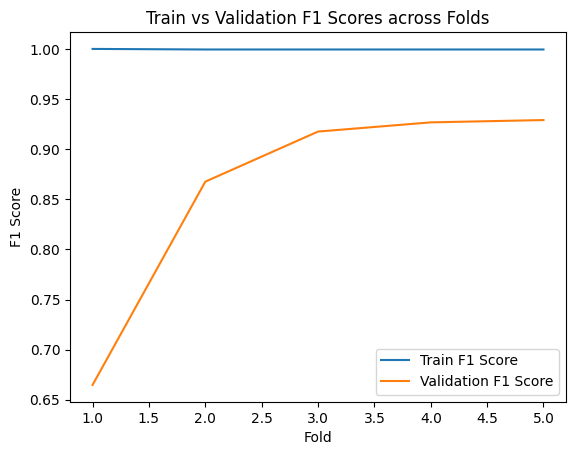

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       237
           1       0.41      0.51      0.45        63

    accuracy                           0.74       300
   macro avg       0.64      0.66      0.64       300
weighted avg       0.77      0.74      0.75       300



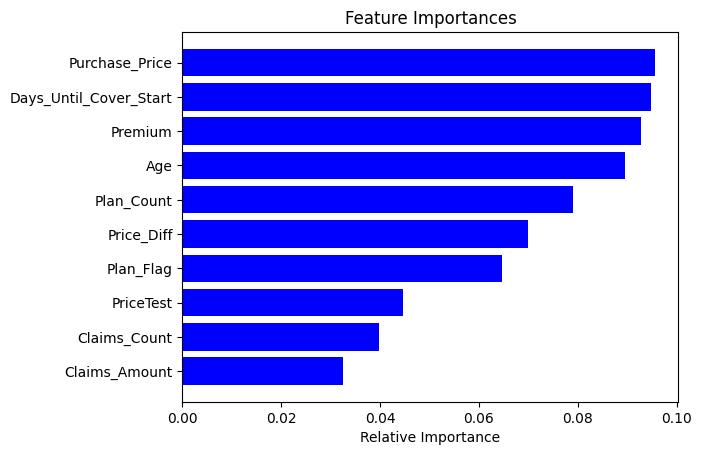

In [3]:

# Prepare X and y
X = data.drop('Sale_Flag', axis=1)
y = data['Sale_Flag']

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Random Forest with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Manually iterating over the folds
kf = StratifiedKFold(n_splits=5)
train_f1_scores = []
val_f1_scores = []

for train_index, val_index in kf.split(X_train_smote, y_train_smote):
    X_train_fold, X_val_fold = X_train_smote[train_index], X_train_smote[val_index]
    y_train_fold, y_val_fold = y_train_smote[train_index], y_train_smote[val_index]

    best_rf = grid_search.best_estimator_
    best_rf.fit(X_train_fold, y_train_fold)

    train_f1_scores.append(f1_score(y_train_fold, best_rf.predict(X_train_fold)))
    val_f1_scores.append(f1_score(y_val_fold, best_rf.predict(X_val_fold)))

# Plotting the F1 scores
plt.plot(range(1, 6), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, 6), val_f1_scores, label='Validation F1 Score')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Train vs Validation F1 Scores across Folds')
plt.legend()
plt.show()

# Adjust Decision Threshold
best_rf = grid_search.best_estimator_
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_prob >= 0.4).astype(int)
original_predictions = y_pred_adjusted.copy()
print(classification_report(y_test, y_pred_adjusted))

# Feature Importance Graph
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



As we can see we are getting exactly the same classification report even though we added new features to the dataset. Random Forest, by its nature, attempts to select the most informative features during the tree-building process. If the new features don't provide new insights or are overshadowed by the predictive power of existing features, their addition won't impact them model's performance.

Random Forest models can be quite complex, with many trees making decisions based on subsets of features. If the initla  model was already performing well with the original set of features, the new features might not significantly alter the decision boundaries established by the ensemble of trees.

## Impact of a 10% flat price increase in the demand

In [4]:
# Increase the Purchase_Price by 10%
data['Purchase_Price'] *= 1.10

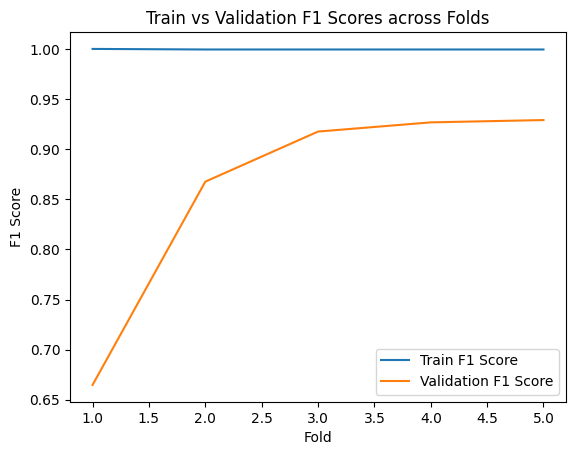

In [5]:

# Prepare X and y
X = data.drop('Sale_Flag', axis=1)
y = data['Sale_Flag']

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Random Forest with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Manually iterating over the folds
kf = StratifiedKFold(n_splits=5)
train_f1_scores = []
val_f1_scores = []

for train_index, val_index in kf.split(X_train_smote, y_train_smote):
    X_train_fold, X_val_fold = X_train_smote[train_index], X_train_smote[val_index]
    y_train_fold, y_val_fold = y_train_smote[train_index], y_train_smote[val_index]

    best_rf = grid_search.best_estimator_
    best_rf.fit(X_train_fold, y_train_fold)

    train_f1_scores.append(f1_score(y_train_fold, best_rf.predict(X_train_fold)))
    val_f1_scores.append(f1_score(y_val_fold, best_rf.predict(X_val_fold)))

# Plotting the F1 scores
plt.plot(range(1, 6), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, 6), val_f1_scores, label='Validation F1 Score')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Train vs Validation F1 Scores across Folds')
plt.legend()
plt.show()

# Adjust Decision Threshold
best_rf = grid_search.best_estimator_
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_prob >= 0.4).astype(int)





In [6]:
y_pred_adjusted

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [7]:
original_predictions

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [8]:
change_in_predictions = y_pred_adjusted - original_predictions
change_in_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Subtraction in as easy way to see if there is any difference in the final predictions after adjusting the threshold. All values are 0s and that means that the 10% increase in the price did not affect at all the model's prediction in terms of the final outcome. We could investigate what is the difference in the predicted probabiblities before we set the decision threshold. 